In [1]:
import numpy as np
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
from kneed import KneeLocator
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score as ss
import itertools
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv("events-sep-nov-2020.csv")

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 876422 entries, 0 to 876421
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   event_time     377843 non-null  object 
 1   event_type     377843 non-null  object 
 2   product_id     377843 non-null  float64
 3   category_id    377843 non-null  float64
 4   category_code  267706 non-null  object 
 5   brand          283072 non-null  object 
 6   price          377843 non-null  float64
 7   user_id        377843 non-null  float64
 8   user_session   377753 non-null  object 
dtypes: float64(4), object(5)
memory usage: 60.2+ MB


In [4]:
data.describe()

,product_id,category_id,price,user_id
count,3.778430e+05,3.778430e+05,377843.000000,3.778430e+05
mean,1.751263e+06,2.144429e+18,118.687598,1.515920e+18
std,1.406400e+06,7.168226e+14,301.300241,1.451266e+06
min,1.020000e+02,2.144420e+18,0.220000,1.515920e+18
25%,6.417240e+05,2.144420e+18,23.170000,1.515920e+18
50%,1.283107e+06,2.144420e+18,55.560000,1.515920e+18
75%,3.580832e+06,2.144420e+18,136.050000,1.515920e+18
max,4.183880e+06,2.227850e+18,64771.060000,1.515920e+18


In [5]:
data['event_time'] = pd.to_datetime(data['event_time'])
print(data['event_time'].min())
print(data['event_time'].max())

2020-09-24 11:57:06+00:00
2020-11-30 23:57:41+00:00


In [6]:
data.isna().sum()

event_time       498579
event_type       498579
product_id       498579
category_id      498579
category_code    608716
brand            593350
price            498579
user_id          498579
user_session     498669
dtype: int64

In [7]:
data.nunique(0)

event_time       360774
event_type            3
product_id        40951
category_id           7
category_code       107
brand               944
price             11074
user_id               1
user_session     220097
dtype: int64

In [8]:
# check the blanks row in dataset
data[data.isnull().all(axis=1)]

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
377843,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
377844,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
377845,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
377846,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
377847,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
876417,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
876418,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
876419,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
876420,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Data Preparation

### Data Cleaning

In [9]:
data.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2020-09-24 11:57:06+00:00,view,1996170.0,2.144420e+18,electronics.telephone,NaN,31.90,1.515920e+18,LJuJVLEjPT
1,2020-09-24 11:57:26+00:00,view,139905.0,2.144420e+18,computers.components.cooler,zalman,17.16,1.515920e+18,tdicluNnRY
2,2020-09-24 11:57:27+00:00,view,215454.0,2.144420e+18,NaN,NaN,9.81,1.515920e+18,4TMArHtXQy
3,2020-09-24 11:57:33+00:00,view,635807.0,2.144420e+18,computers.peripherals.printer,pantum,113.81,1.515920e+18,aGFYrNgC08
4,2020-09-24 11:57:36+00:00,view,3658723.0,2.144420e+18,NaN,cameronsino,15.87,1.515920e+18,aa4mmk0kwQ


In [10]:
#remove user_id, because it has only one unique value
data.drop(columns=['user_id'], inplace=True)

In [11]:
# remove blank rows
data.dropna(axis=0, how='all', inplace=True)

In [12]:
print(data.shape)
print('\n')
print(data.isnull().sum())
print('\n')
print(data.nunique())

(377843, 8)


event_time            0
event_type            0
product_id            0
category_id           0
category_code    110137
brand             94771
price                 0
user_session         90
dtype: int64


event_time       360774
event_type            3
product_id        40951
category_id           7
category_code       107
brand               944
price             11074
user_session     220097
dtype: int64


### To check each 'product_id' has its own unique variables 

In [13]:
check_unique = data.copy()
check_unique.fillna(value='none', inplace=True)
check_unique = check_unique.groupby('product_id')['category_id', 'category_code', 'brand', 'price'].nunique()
print(check_unique.shape)
check_unique.loc['Average']= check_unique.mean(numeric_only=True, axis=0)
check_unique

(40951, 4)


,category_id,category_code,brand,price
product_id,,,,
102.0,1.0,1.0,1.0,1.0
105.0,1.0,1.0,1.0,1.0
109.0,1.0,1.0,1.0,1.0
526.0,1.0,1.0,1.0,1.0
561.0,1.0,1.0,1.0,1.0
...,...,...,...,...
4183876.0,1.0,1.0,1.0,1.0
4183877.0,1.0,1.0,1.0,1.0
4183878.0,1.0,1.0,1.0,1.0


### Event counts and 'Price' of each 'product_id'

In [14]:
event_counts = data.groupby(['product_id', 'event_type']).size().unstack(fill_value=0)
event_counts['total_event'] = event_counts.sum(axis=1)
#event_counts.reset_index(inplace=True)
event_counts

event_type,cart,purchase,view,total_event
product_id,,,,
102.0,3,5,14,22
105.0,7,3,279,289
109.0,0,0,21,21
526.0,2,1,20,23
561.0,0,0,1,1
...,...,...,...,...
4183875.0,3,3,24,30
4183876.0,1,0,9,10
4183877.0,0,0,3,3


In [15]:
price = data.groupby('product_id')['price'].mean()

In [16]:
price

product_id
102.0         13.02
105.0         14.19
109.0         11.52
526.0         12.54
561.0         10.76
              ...  
4183875.0    377.46
4183876.0    573.98
4183877.0     43.40
4183878.0     42.60
4183880.0     44.21
Name: price, Length: 40951, dtype: float64

In [17]:
df = event_counts.join(price)

In [18]:
df.head()

,cart,purchase,view,total_event,price
product_id,,,,,
102.0,3,5,14,22,13.02
105.0,7,3,279,289,14.19
109.0,0,0,21,21,11.52
526.0,2,1,20,23,12.54
561.0,0,0,1,1,10.76


## EDA

In [19]:
df.describe()

,cart,purchase,view,total_event,price
count,40951.000000,40951.000000,40951.000000,40951.000000,40951.000000
mean,0.502454,0.362799,8.361456,9.226710,108.632771
std,4.231579,3.180108,36.776646,43.216163,545.537871
min,0.000000,0.000000,0.000000,1.000000,0.220000
25%,0.000000,0.000000,1.000000,1.000000,15.710000
50%,0.000000,0.000000,2.000000,3.000000,32.060000
75%,0.000000,0.000000,6.000000,6.000000,85.770000
max,447.000000,248.000000,3383.000000,4078.000000,64771.060000


In [34]:
event = pd.DataFrame(data['event_type'].value_counts().reset_index())
event.rename(columns = {'index':'event_type', 'event_type':'count'}, inplace = True)

In [35]:
event

,event_type,count
0,view,342410
1,cart,20576
2,purchase,14857


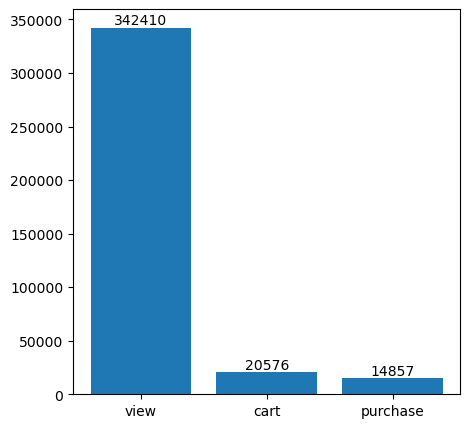

In [36]:
# plot event_type distribution
fig = plt.figure(figsize=(5, 5))
plt.bar(event['event_type'], event['count'])

# Add count text on the bar columns
for i, count in enumerate(event['count']):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.show()

In [37]:
columns = ['cart','purchase','view','total_event','price']

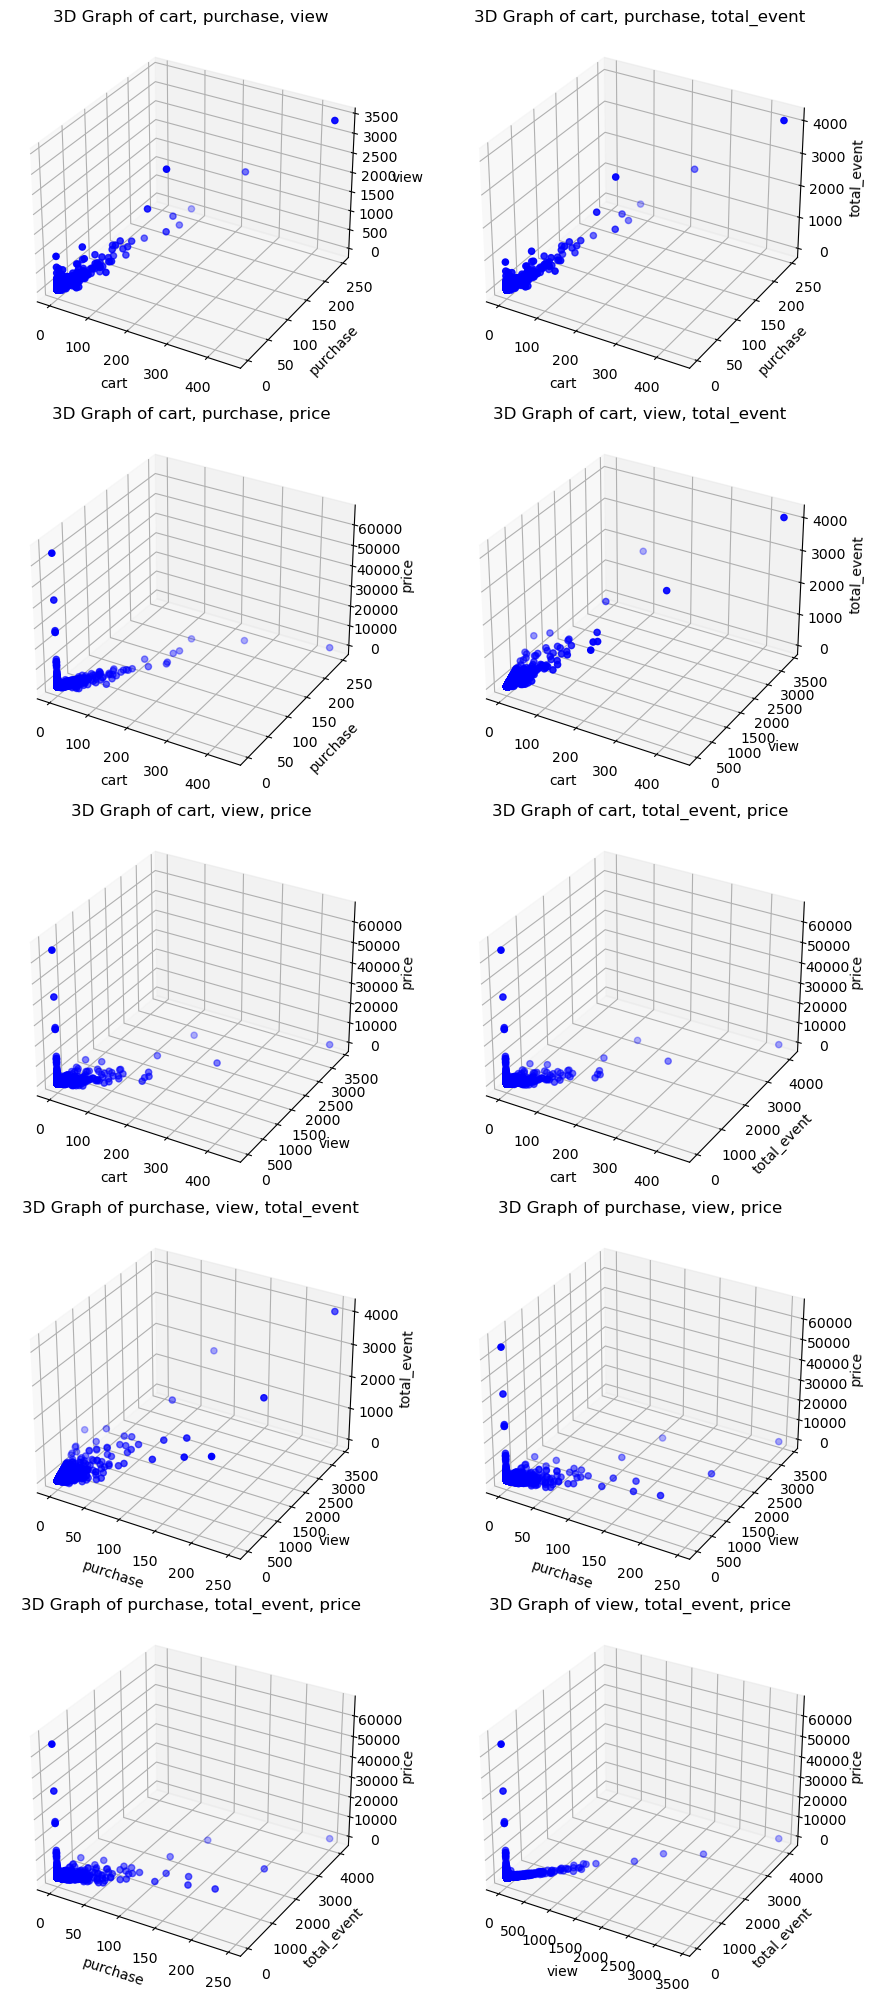

In [38]:
# Generate all combinations of 3 columns
combinations = list(itertools.combinations(range(len(columns)), 3))
# Set the grid layout
num_rows = 5
num_cols = 2

# Create the figure and subplots
fig = plt.figure(figsize=(10, 20))

# Iterate over all combinations and plot the 3D graphs
for i, combination in enumerate(combinations):
    a, b, c = combination
    ax = fig.add_subplot(num_rows, num_cols, i+1, projection='3d')  
    ax.scatter(df[columns[a]], df[columns[b]], df[columns[c]], c='blue', marker='o')
    ax.set_xlabel(columns[a])
    ax.set_ylabel(columns[b])
    ax.set_zlabel(columns[c])
    ax.set_title(f'3D Graph of {columns[a]}, {columns[b]}, {columns[c]}')
    
plt.tight_layout()
plt.show()

In [ ]:
# Select the columns for PCA
columns = ['cart', 'purchase', 'view', 'total_event', 'price']

# Perform PCA
pca = PCA(n_components=3)
pca_result = pca.fit_transform(df[columns])

# Create a 3D scatter plot of PCA results with specified colors
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for i, label in enumerate(df['kmeans_4'].unique()):
    mask = df['kmeans_4'] == label
    ax.scatter(pca_result[mask, 0], pca_result[mask, 1], pca_result[mask, 2], color=colors[i], label=f'Label {label}')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('3D PCA')
ax.legend()
plt.show()


### Feature Scaling

In [39]:
scaler = StandardScaler()
scaled_df = df.copy()

In [40]:
scaled_df[['cart','purchase','view','total_event','price']] = scaler.fit_transform(
    scaled_df[['cart','purchase','view','total_event','price']])

In [41]:
scaled_df

,cart,purchase,view,total_event,price
product_id,,,,,
102.0,0.590223,1.458207,0.153320,0.295571,-0.175265
105.0,1.535508,0.829290,7.359068,6.473891,-0.173121
109.0,-0.118741,-0.114085,0.343661,0.272431,-0.178015
526.0,0.353902,0.200373,0.316469,0.318711,-0.176145
561.0,-0.118741,-0.114085,-0.200169,-0.190364,-0.179408
...,...,...,...,...,...
4183875.0,0.590223,0.829290,0.425235,0.480689,0.492781
4183876.0,0.117581,-0.114085,0.017363,0.017894,0.853017
4183877.0,-0.118741,-0.114085,-0.145786,-0.144085,-0.119577


In [42]:
X = scaled_df[['cart','purchase','view','total_event','price']].to_numpy()

In [43]:
X

array([[ 0.59022321,  1.45820748,  0.15332046,  0.29557104, -0.17526545],
       [ 1.53550829,  0.82929033,  7.35906822,  6.47389054, -0.17312075],
       [-0.1187406 , -0.1140854 ,  0.34366097,  0.27243126, -0.17801506],
       ...,
       [-0.1187406 , -0.1140854 , -0.14578605, -0.14408466, -0.11957661],
       [-0.1187406 , -0.1140854 , -0.09140304, -0.09780511, -0.12104307],
       [ 0.11758067,  0.20037318,  0.91468249,  0.80464605, -0.11809182]])

## K-Means

### Identify optimum number of cluster

In [42]:
# Create function to work out optimum number of clusters
inertias = []
def optimise_k_means(data, max_k):
    means = []
    
    
    for k in range (1, max_k): 
        kmeans = KMeans(n_clusters = k)
        kmeans.fit(data)
        means.append(k)
        inertias.append(kmeans.inertia_)
    # generate elbow plot
    #fig = plt.subplots(figsize=(10,5))
    #plt.plot(means, inertias, 'o-')
    #plt.xlabel('Number of Clusters')
    #plt.ylabel('Inertia')
    #plt.grid(True)
    #plt.show()
    
    knee = KneeLocator(x = range(1,10), y = inertias, curve='convex', direction='decreasing', online=True)

    # Get the indices of the knee points on x-axis and y-axis
    knee_x_index = knee.knee
    knee_y = inertias[knee_x_index]

    # Plot the knee point on the graph
    plt.plot(inertias)
    plt.grid(True)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.axvline(x=knee_x_index, color='r', linestyle='--', label='Knee Point (X-axis)')
    plt.axhline(y=knee_y, color='g', linestyle='--', label='Knee Point (Y-axis)')
    plt.legend()
    plt.show()

    # Print the x and y coordinates of the knee point
    print(f"Knee Point Coordinates: ({knee_x_index}, {knee_y})")


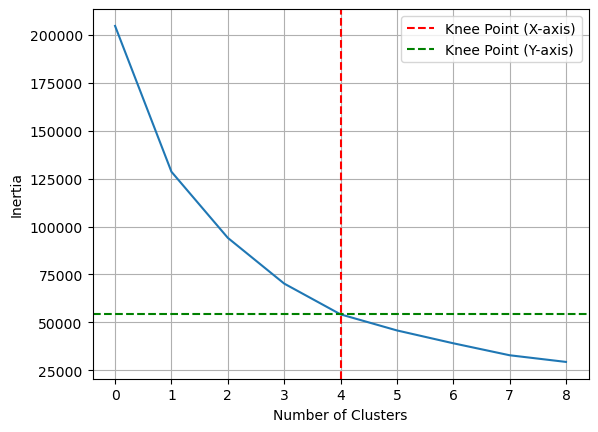

Knee Point Coordinates: (4, 54154.950438659034)


In [43]:
optimise_k_means(X, 10)

In [44]:
cost_knee_c3 = KneeLocator(
        x=range(1,10), 
        y=inertias, 
        S=0.1, curve="convex", direction="decreasing", online=True)

K_cost_c3 = cost_knee_c3.elbow   
print("elbow at k =", f'{K_cost_c3:.0f} clusters')

elbow at k = 4 clusters


### Clustering Model

In [45]:
kmeans = KMeans(n_clusters = 4)
kmeans.fit(X)

KMeans(n_clusters=4)

In [46]:
scaled_df['kmeans_4'] = kmeans.labels_
df['kmeans_4'] = kmeans.labels_
df['kmeans_4'].value_counts()

0    40756
2      182
1        8
3        5
Name: kmeans_4, dtype: int64

In [47]:
def plot3D(method):
    # Generate all combinations of 3 columns
    combinations = list(itertools.combinations(range(len(columns)), 3))

    # Iterate over all combinations and plot the 3D graphs
    for combination in combinations:
        a, b, c = combination
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        labels = method
        colors = ['blue', 'red', 'green', 'black']  # Define colors for each label
        for label in labels.unique():
            indices = labels == label
            ax.scatter(df[columns[a]][indices], df[columns[b]][indices], df[columns[c]][indices], 
                   c=colors[label], marker='o', label=f'Label {label}')
        ax.set_xlabel(columns[a])
        ax.set_ylabel(columns[b])
        ax.set_zlabel(columns[c])
        ax.legend()
    plt.show()

In [50]:
def plot3Dsub(method):
    labels = method
    # Generate all combinations of 3 columns
    combinations = list(itertools.combinations(range(len(columns)), 3))

    # Set the grid layout
    num_rows = 5
    num_cols = 2

    # Create the figure and subplots
    fig = plt.figure(figsize=(10, 20))

    # Iterate over all combinations and plot the 3D graphs
    for i, combination in enumerate(combinations):
        a, b, c = combination
        ax = fig.add_subplot(num_rows, num_cols, i+1, projection='3d')
        labels = method
        colors = ['blue', 'red', 'green', 'black']  # Define colors for each label
        for label in labels.unique():
            indices = labels == label
            ax.scatter(df[columns[a]][indices], df[columns[b]][indices], df[columns[c]][indices], 
                   c=colors[label], marker='o', label=f'Label {label}')
        #ax.scatter(df[columns[a]], df[columns[b]], df[columns[c]], c=labels, cmap='Set1', marker='o')
        ax.set_xlabel(columns[a])
        ax.set_ylabel(columns[b])
        ax.set_zlabel(columns[c])
        ax.set_title(f'3D Graph of {columns[a]}, {columns[b]}, {columns[c]}')
        ax.legend()
    
    plt.tight_layout()
    plt.show()

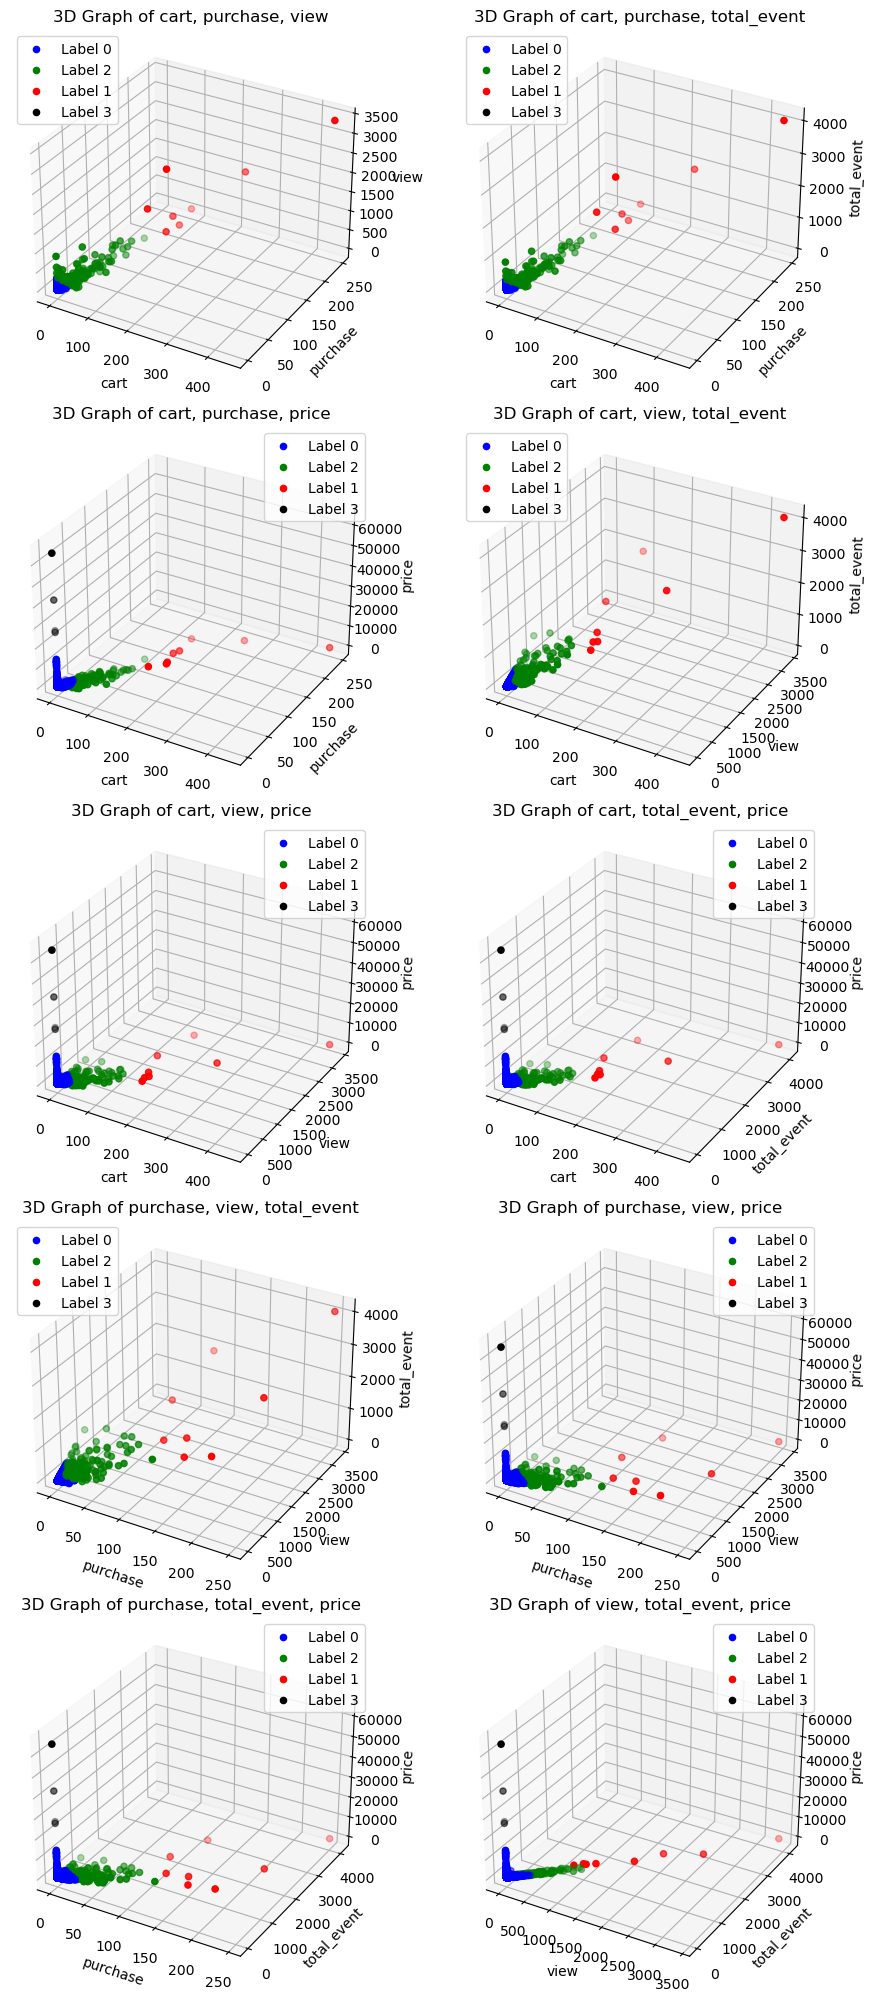

In [51]:
plot3Dsub(df['kmeans_4'])

In [54]:
def plot2Dsub(method):

    columns = ['cart', 'purchase', 'view', 'total_event', 'price']

    combinations = list(itertools.combinations(range(len(columns)), 2))

    # Set the grid layout
    num_rows = 5
    num_cols = 2

    # Create the figure and subplots
    fig = plt.figure(figsize=(10, 20))

    # Iterate over all combinations and plot the 3D graphs
    for i, combination in enumerate(combinations):
        a, b = combination
        ax = fig.add_subplot(num_rows, num_cols, i+1)
        labels = method
        colors = ['blue', 'red', 'green', 'black']  # Define colors for each label
        for label in labels.unique():
            indices = labels == label
            ax.scatter(df[columns[a]][indices], df[columns[b]][indices], 
                   c=colors[label], marker='o', label=f'Label {label}')
        ax.set_xlabel(columns[a])
        ax.set_ylabel(columns[b])
        ax.set_title(f'2D Scatter Plot of {columns[a]}, {columns[b]}')
        ax.legend()
    
    plt.tight_layout()
    plt.show()

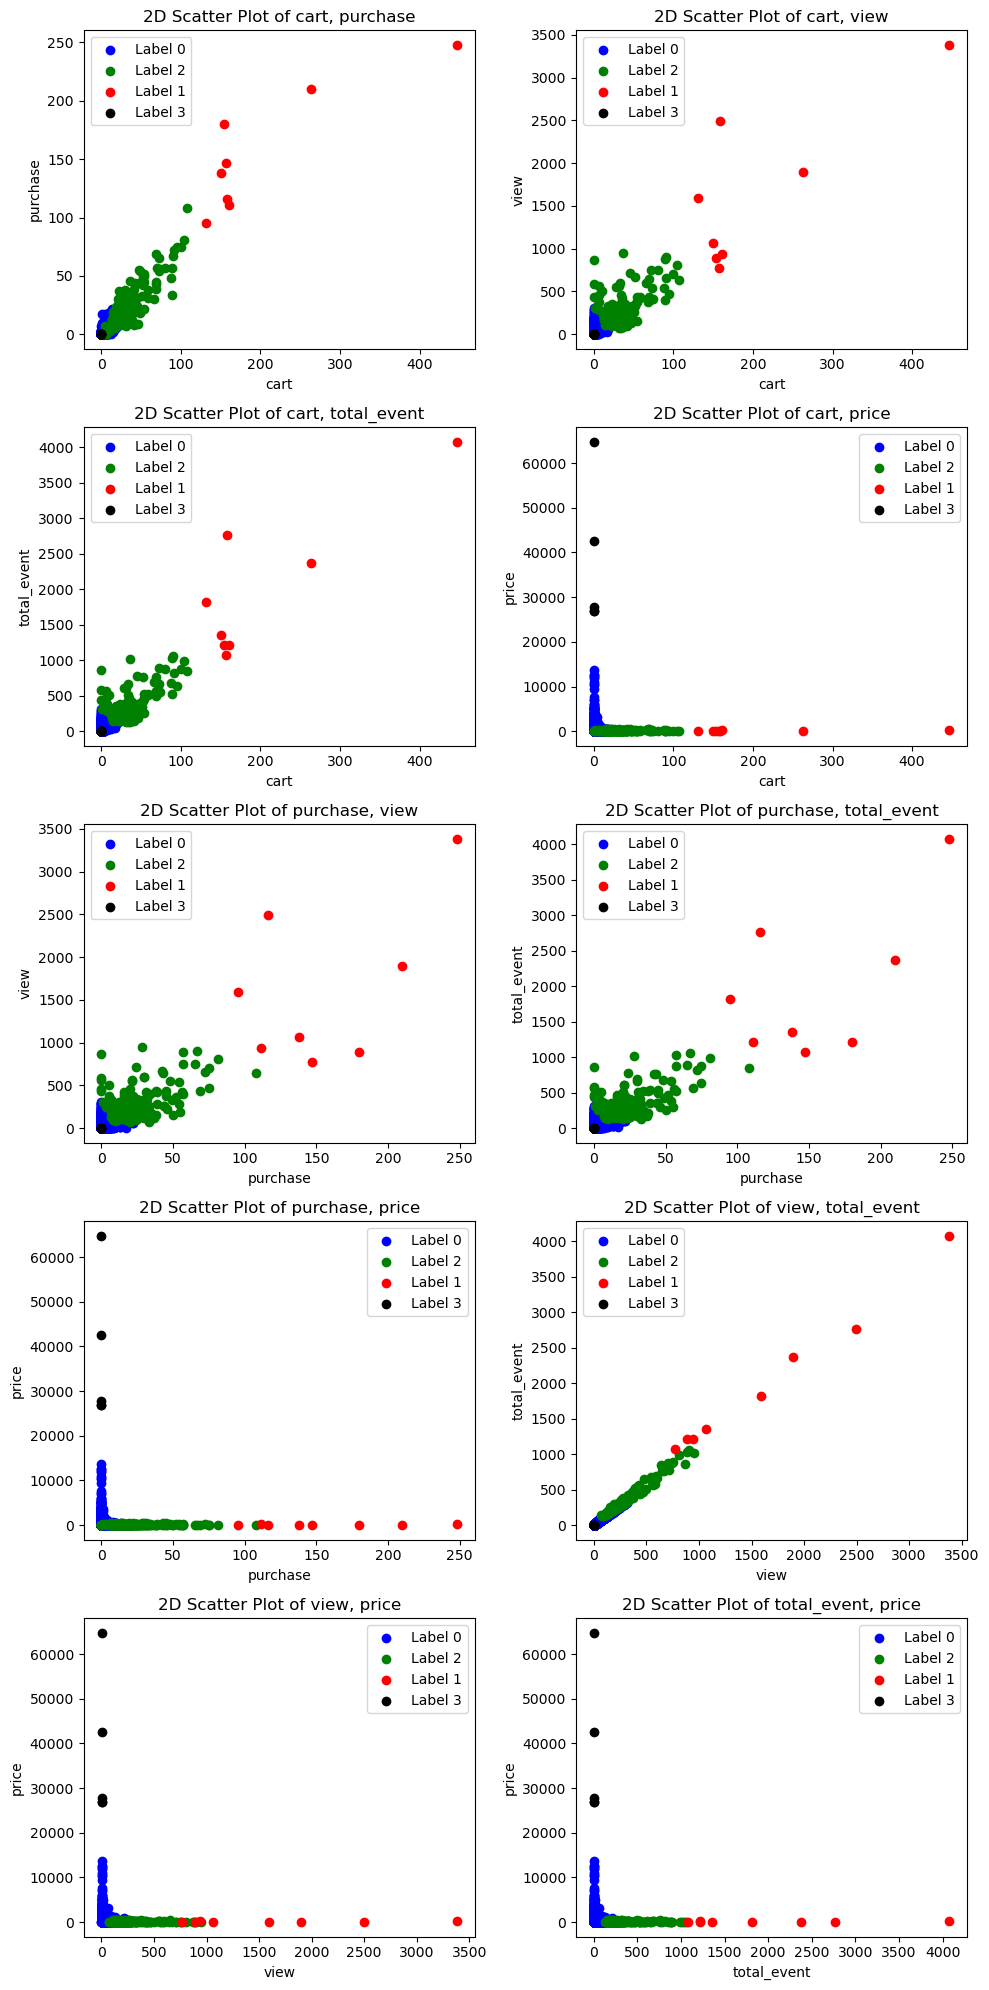

In [55]:
plot2Dsub(df['kmeans_4'])

In [56]:
def plot2D(method):
    combinations = list(itertools.combinations(range(len(columns)), 2))

    # Iterate over all combinations and plot the 3D graphs
    for combination in combinations:
        a, b = combination
        fig = plt.figure()
        ax = fig.add_subplot(111)
        labels = method
        colors = ['blue', 'red', 'green', 'black']  # Define colors for each label
        for label in labels.unique():
            indices = labels == label
            ax.scatter(df[columns[a]][indices], df[columns[b]][indices], c=colors[label], 
                   marker='o', label=f'Label {label}')
        ax.set_xlabel(columns[a])
        ax.set_ylabel(columns[b])
        ax.legend()
    plt.show()

## DBSCAN

### Identify optimum parameters (epsilon & min_samples)

#### K-distance Graph Method to Find optimum 'epsilon'

In [52]:
X.shape

(40951, 5)

This dataset has 5 dimensions. We can go with 10 (2*dim) as the 'min_samples', as suggested in the literature.

After selecting MinPts value, we can use NearestNeighbors from Scikit-learn, documentation here, to calculate the average distance between each point and its n_neighbors. The one parameter we need to define is n_neighbors, which in this case is the value we choose for MinPts.

In [63]:
# Calculate the average distance between each point in the data set and 
# its 20 nearest neighbors (my selected MinPts value).

from sklearn.neighbors import NearestNeighbors
 
neighbors = NearestNeighbors(n_neighbors=10)
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X)

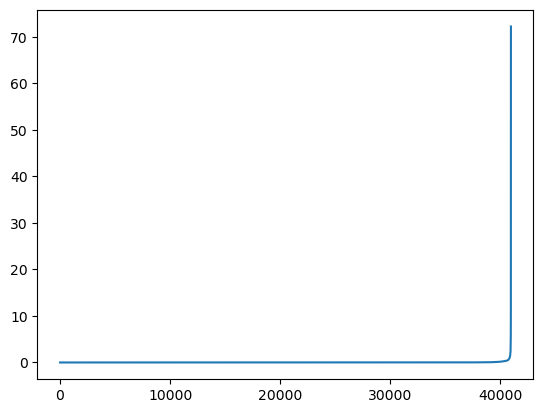

In [64]:
# Sort distance values by ascending value and plot.

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [67]:
print(distances)

[ 0.          0.          0.         ... 40.6593236  42.85432206
 72.25205092]


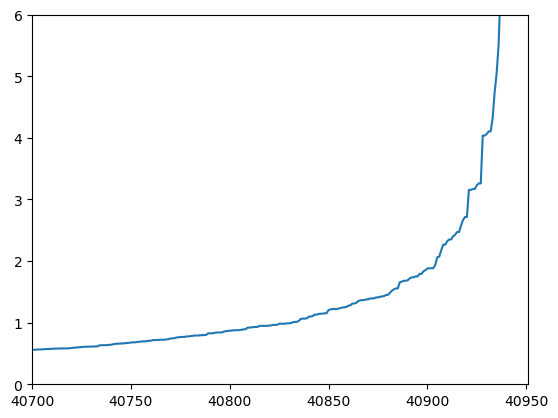

In [82]:
distances = np.sort(distances)
plt.plot(distances)
plt.ylim(0, 6)  # Set y-axis range
plt.xlim(40700, 40951)  # Set x-axis range
plt.show()

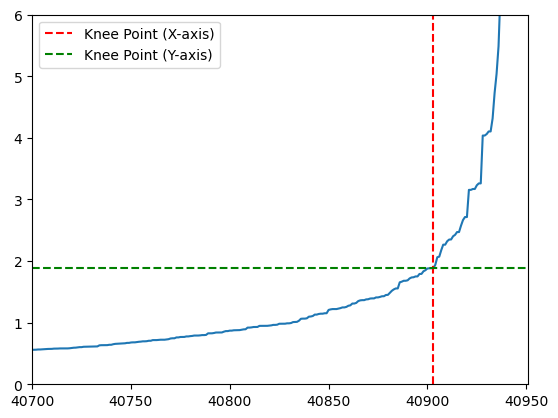

Knee Point Coordinates: (40903, 1.8842969336329463)


In [83]:
knee = KneeLocator(range(len(distances)), distances, curve='convex', direction='increasing')

# Get the indices of the knee points on x-axis and y-axis
knee_x_index = knee.knee
knee_y = distances[knee_x_index]

# Plot the knee point on the graph
plt.plot(distances)
plt.ylim(0, 6)
plt.xlim(40700, 40951)
plt.axvline(x=knee_x_index, color='r', linestyle='--', label='Knee Point (X-axis)')
plt.axhline(y=knee_y, color='g', linestyle='--', label='Knee Point (Y-axis)')
plt.legend()
plt.show()

# Print the x and y coordinates of the knee point
print(f"Knee Point Coordinates: ({knee_x_index}, {knee_y})")


#### Trial and Error Method to Find 'min_samples'

In [171]:
epsilons =[knee_y]

In [172]:
min_samples = np.arange(1, 10, step=1)
min_samples

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

In [173]:
combinations = list(itertools.product(epsilons, min_samples))
combinations

[(1.8842969336329463, 1),
 (1.8842969336329463, 2),
 (1.8842969336329463, 3),
 (1.8842969336329463, 4),
 (1.8842969336329463, 5),
 (1.8842969336329463, 6),
 (1.8842969336329463, 7),
 (1.8842969336329463, 8),
 (1.8842969336329463, 9)]

In [131]:
N = len(combinations)
N

9

In [132]:
best_dict = get_scores_and_labels(combinations, X)

Combination (1.8842969336329463, 1) on iteration 1 of 9 has 63 clusters. Moving on
Index: 1, Score: 0.9300412597427381, Labels: [0 0 0 ... 0 0 0], NumClusters: 16
Index: 2, Score: 0.9307601490802245, Labels: [0 0 0 ... 0 0 0], NumClusters: 6
Index: 3, Score: 0.9536491535720459, Labels: [0 0 0 ... 0 0 0], NumClusters: 3
Index: 4, Score: 0.9665351184410476, Labels: [0 0 0 ... 0 0 0], NumClusters: 2
Combination (1.8842969336329463, 6) on iteration 6 of 9 has 1 clusters. Moving on
Combination (1.8842969336329463, 7) on iteration 7 of 9 has 1 clusters. Moving on
Combination (1.8842969336329463, 8) on iteration 8 of 9 has 1 clusters. Moving on
Combination (1.8842969336329463, 9) on iteration 9 of 9 has 1 clusters. Moving on


In [133]:
best_dict

{'best_epsilon': 1.8842969336329463,
 'best_min_samples': 5,
 'best_labels': array([0, 0, 0, ..., 0, 0, 0]),
 'best_score': 0.9665351184410476}

In [174]:
scaled_df['dbs'] = best_dict['best_labels']
df['dbs'] = best_dict['best_labels']
df['dbs'].value_counts()

 0    40856
-1       89
 1        6
Name: dbs, dtype: int64

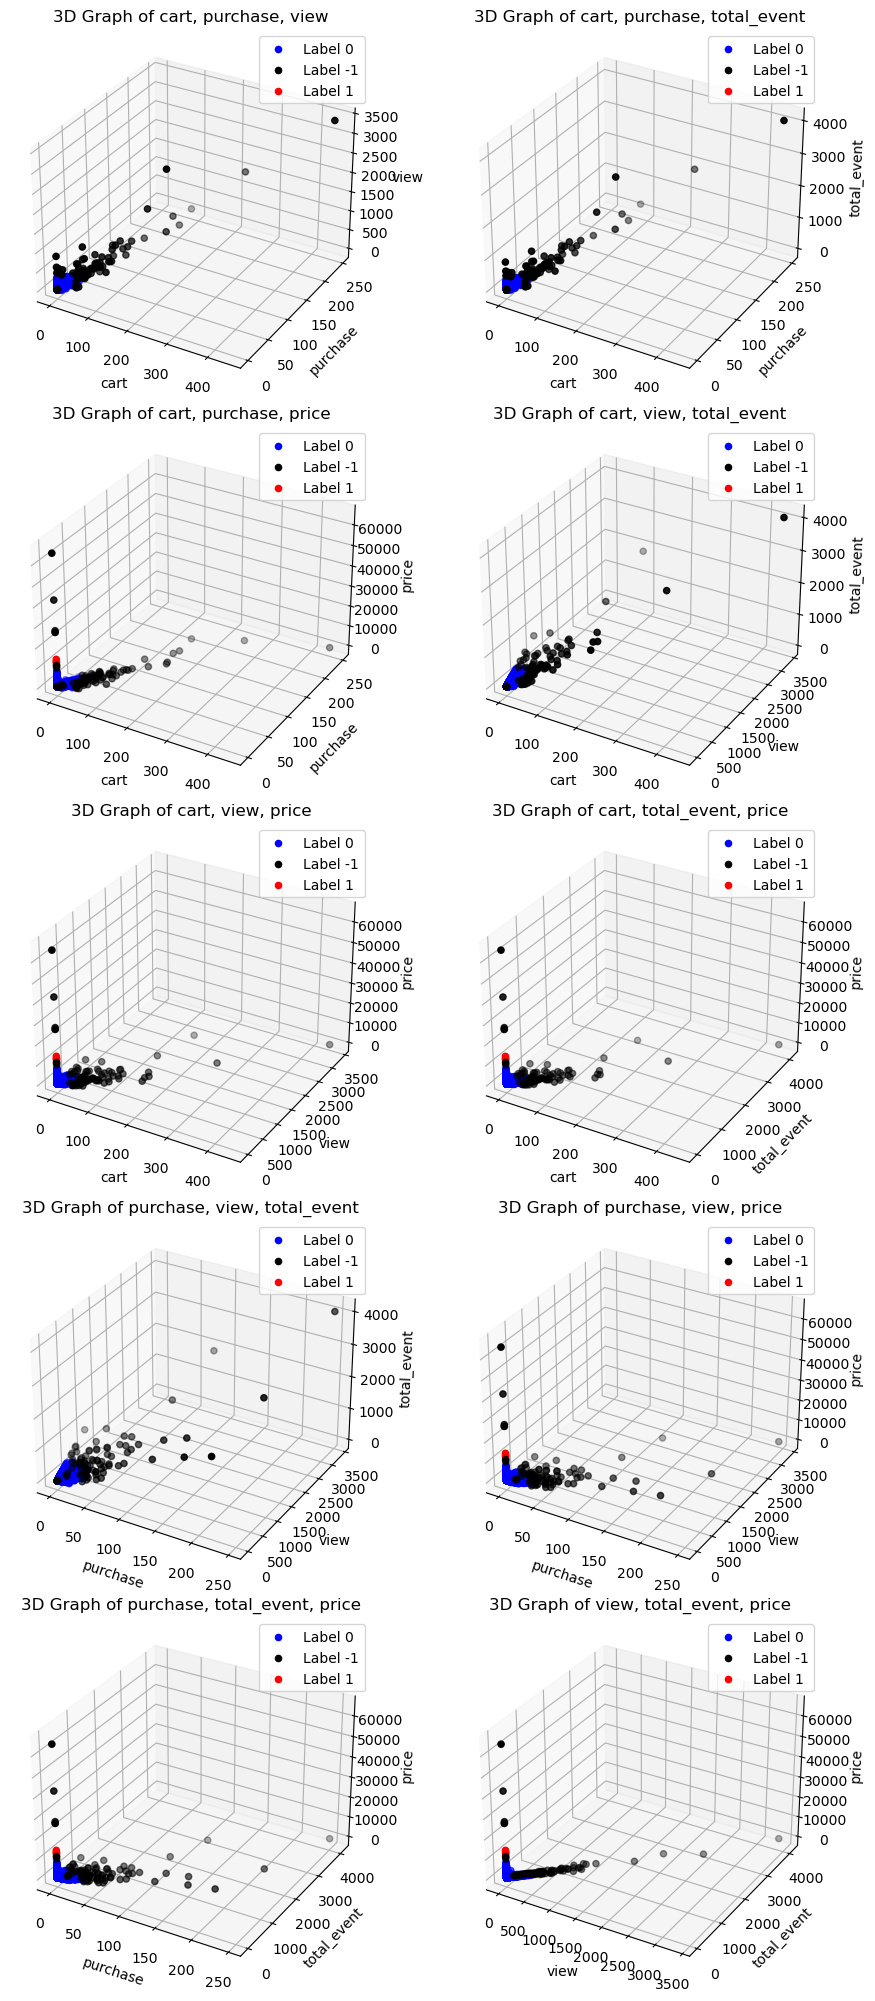

In [272]:
plot3Dsub(df['dbs'])

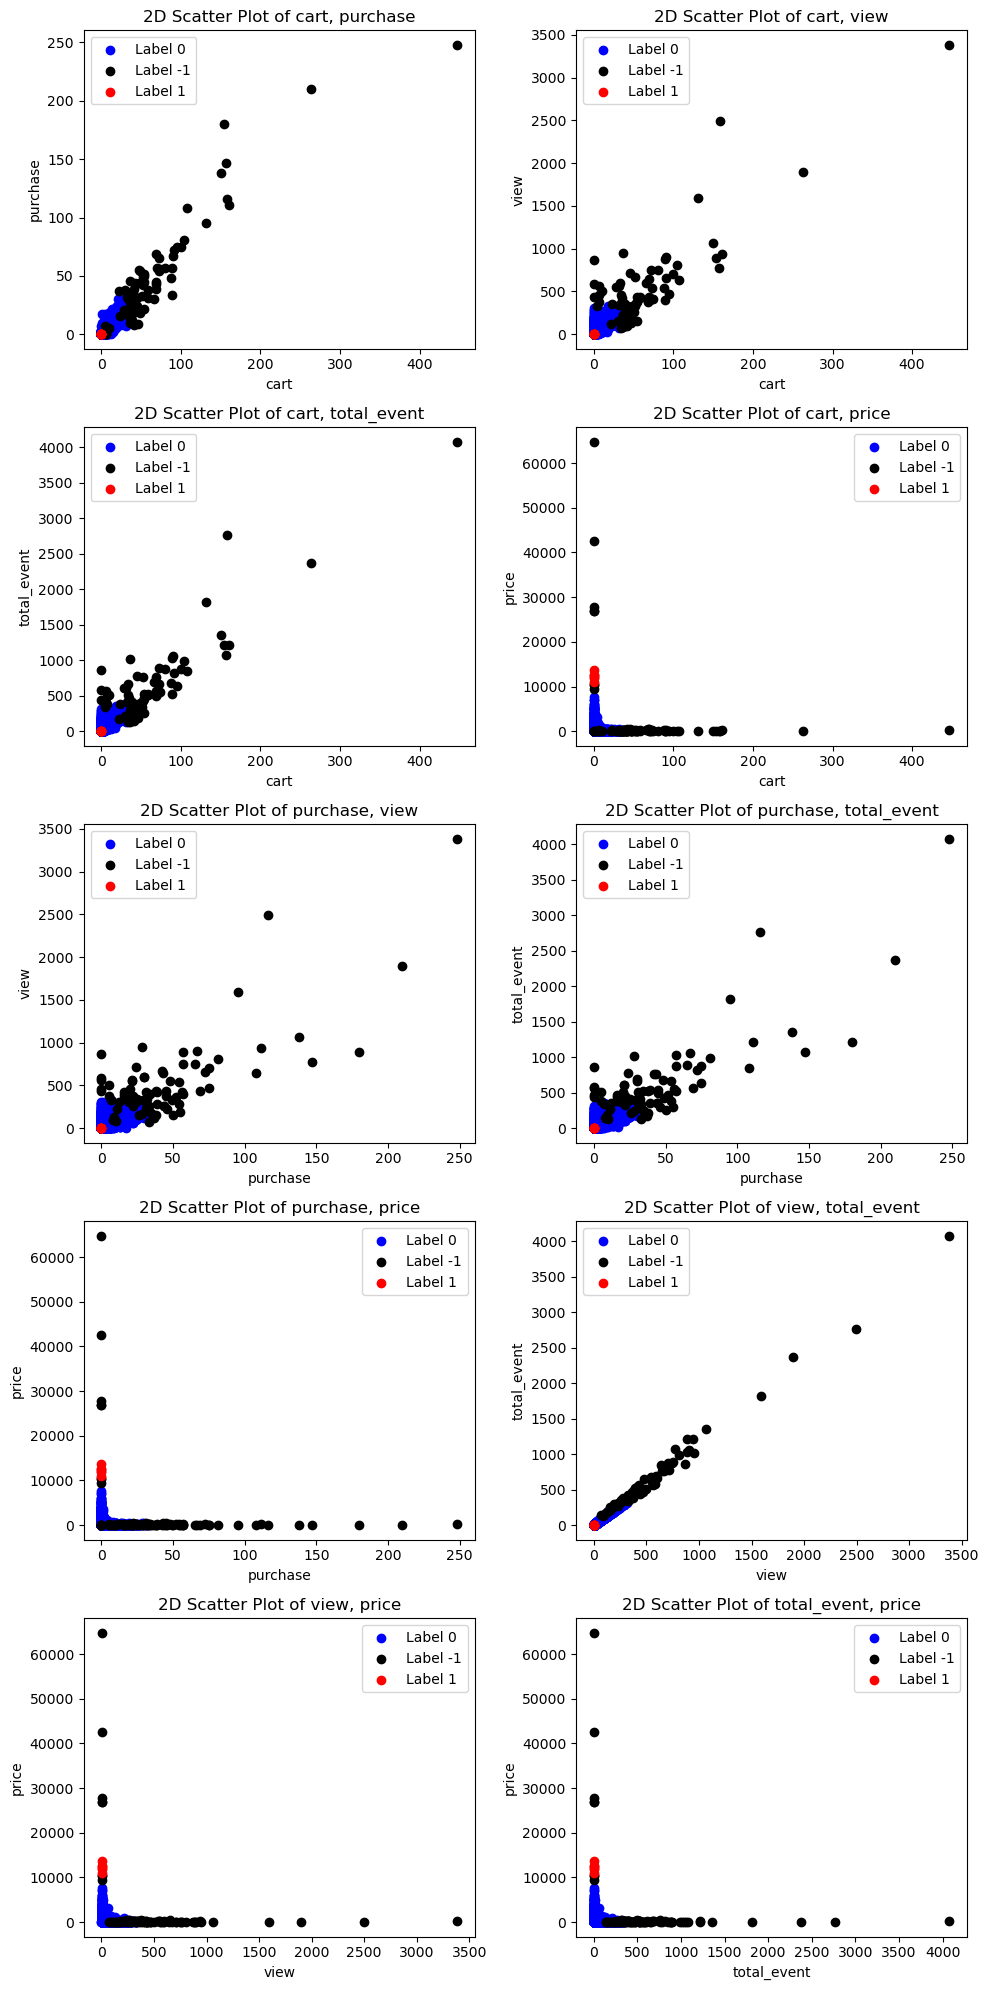

In [276]:
plot2Dsub(df['dbs'])

In [102]:
from sklearn.decomposition import PCA

# Select the columns for PCA
columns = ['cart', 'purchase', 'view', 'total_event', 'price']

# Perform PCA
pca = PCA(n_components=3)
pca_result = pca.fit_transform(df[columns])

# Access the loadings
loadings = pca.components_.T  # Transpose to match the shape of columns

# Print the loadings for each PC axis
for i, pc_axis in enumerate(loadings):
    print(f'PC{i+1}:')
    for feature, loading in zip(columns, pc_axis):
        print(f'{feature}: {loading:.3f}')
    print()

PC1:
cart: 0.000
purchase: 0.067
view: 0.526

PC2:
cart: -0.000
purchase: 0.047
view: 0.467

PC3:
cart: 0.000
purchase: 0.646
view: -0.577

PC4:
cart: 0.000
purchase: 0.759
view: 0.416

PC5:
cart: 1.000
purchase: -0.000
view: 0.000



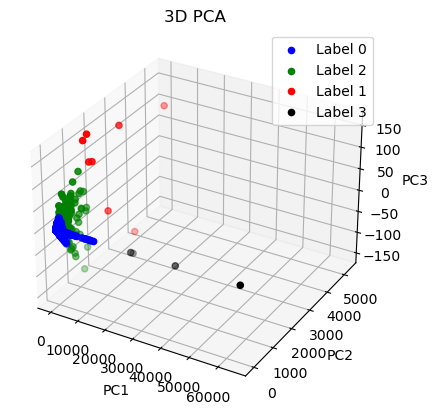

In [104]:
# Select the columns for PCA
columns = ['cart', 'purchase', 'view', 'total_event', 'price']

# Perform PCA
pca = PCA(n_components=3)
pca_result = pca.fit_transform(df[columns])

# Define colors for each label
colors = ['blue', 'green', 'red','black']

# Create a 3D scatter plot of PCA results with specified colors
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for i, label in enumerate(df['kmeans_4'].unique()):
    mask = df['kmeans_4'] == label
    ax.scatter(pca_result[mask, 0], pca_result[mask, 1], pca_result[mask, 2], color=colors[i], label=f'Label {label}')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('3D PCA')
ax.legend()
plt.show()


In [135]:
ss(X, labels)

0.9679560006394683

In [134]:
labels

product_id
102.0        0
105.0        0
109.0        0
526.0        0
561.0        0
            ..
4183875.0    0
4183876.0    0
4183877.0    0
4183878.0    0
4183880.0    0
Name: kmeans_4, Length: 40951, dtype: int32